In [417]:
import pandas as pd
import seaborn as sns

In [418]:
df = pd.read_csv('../data/clean/acs_estimate.csv')
df.head()

,borough,total_housing_units,occupied_housing_units,vacant_housing_units,1_room_units,2_room_units,3_room_units,4_room_units,5_room_units,6_room_units,...,unit_4_bedrooms,unit_5+_bedrooms,owner_occupied_units,renter_occupied_units,occupants_per_room_<=1,occupants_per_room_1-1.5,occupants_per_room_>=1.5,owned_median_value,rent_median_value,year
0,STATEN ISLAND,176696,163816,12880,3145,1881,20330,25117,33485,39302,...,23347,7280,114045,49771,157232,5186,1398,452300,1141,2010
1,BRONX,512024,471912,40112,24251,14502,155923,152272,96979,38867,...,18088,9718,88493,383419,413758,37160,20994,388900,974,2010
2,QUEENS,834965,772332,62633,32996,30863,168537,188746,176340,113793,...,58618,28220,338609,433723,703798,44723,23811,464800,1242,2010
3,MANHATTAN,846962,726090,120872,101223,111830,259565,215744,85654,38519,...,22131,7119,161647,564443,683146,23307,19637,825900,1305,2010
4,BROOKLYN,1000000,905317,94683,50285,44652,242503,280610,180657,95177,...,55736,34036,273500,631817,805170,66843,33304,566700,1079,2010


In [419]:
# HELPER FUNCTIONS 

# Get yearly NYC median average for column `value`
def get_nyc_data(df, value):
    nyc_data = df.groupby(["year"])[value].mean().to_frame().reset_index()
    nyc_data["borough"] = "NYC"
    return nyc_data

# Gets yearly sorty data for any borough based on column `value`
def extract_yearly_sorted_data(df, boro, value):
    return df[df["borough"] == boro][[value, "year", "borough" ]].reset_index(drop=True)

# Create delta column for any data frame column
def create_delta_col(df, value):
    delta_col = value + "_delta"
    df[delta_col] = df[value].diff().replace(np.nan, 0).astype("int")
    return df.drop(columns=[value]).reset_index(drop=True)

In [420]:
# COMPUTATION FUNCTIONS

# Compute yearly delta for NYC
def compute_nyc_delta(df, value):
    data = get_nyc_data(df, value)
    return create_delta_col(data, value)

# Compute yearly delta for any boro based on column `value`
def compute_boro_delta(df, boro, value):
    data = extract_yearly_sorted_data(df, boro, value)
    return create_delta_col(data, value)

# Create delta df for all boros
def compute_all_boros_delta(df, delta_metric):
    boros = df["borough"].unique()
    boros_delta = pd.DataFrame()
    for boro in boros:
        boros_delta = pd.concat([boros_delta, compute_boro_delta(df, boro, delta_metric)])
    return boros_delta

In [421]:
# HELPER FUNCTIONS

# Get color palette based on delta value
def get_delta_colors(delta_list):
    return ["#8CD47E" if i > 0.0 else "#FF6961" for i in delta_list]

# Set annotations for values on bar
def set_bar_annotations(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),\
        (p.get_x() + p.get_width() / 2,\
        p.get_height()), ha='center', va='center',\
        xytext=(0, 8),\
        textcoords='offset points')

# Extracts labeled delta column by removing year and borough from columns list copy
def get_delta_column(columns):
    delta_column = list(columns)
    delta_column.remove("year")
    delta_column.remove("borough")
    return delta_column[0]

def format_label(unformatted_title):
    return unformatted_title.upper().replace("_", " ")
    

In [422]:
# COMPUTATION FUNCTIONS

# Map chart for FacetGrid
def map_delta(data, color):
    df = pd.DataFrame(data)
    
    delta_column = get_delta_column(df.columns.to_list())
    df[delta_column] = df[delta_column].div(1000).round(2)
    
    chart = sns.barplot(x=df["year"], y=df[delta_column], palette=get_delta_colors(df[delta_column].to_list()))
    
    # Format Chart
    set_bar_annotations(chart.axes)
    chart.figure.set_size_inches((6,12))
    chart.axes.tick_params(axis='x', rotation=90)
    chart.axes.set_ylabel("delta (thousands)")
    title = 'yearly {} for {}'.format(delta_column, df["borough"].unique()[0])
    chart.axes.set_title(format_label(title))

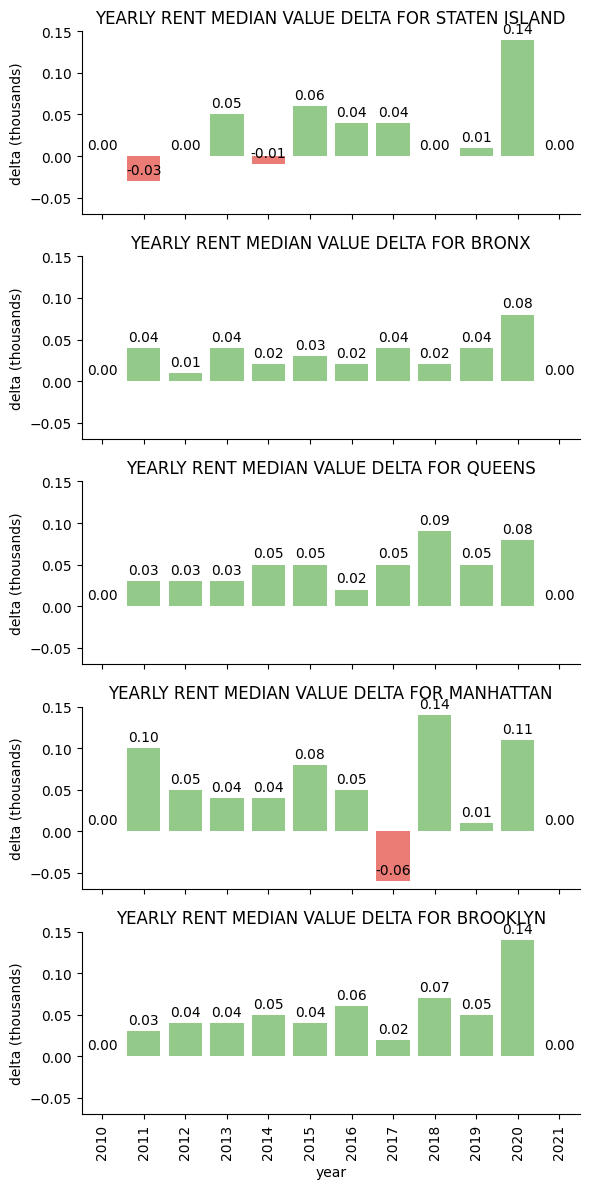

In [423]:
delta_metric = "rent_median_value"

# Get data for boros and NYC
boros_delta = compute_all_boros_delta(df, delta_metric)
nyc_delta = compute_nyc_delta(df, delta_metric)

g = sns.FacetGrid(boros_delta, row="borough")

# Get data for boros
g.map_dataframe(map_delta)

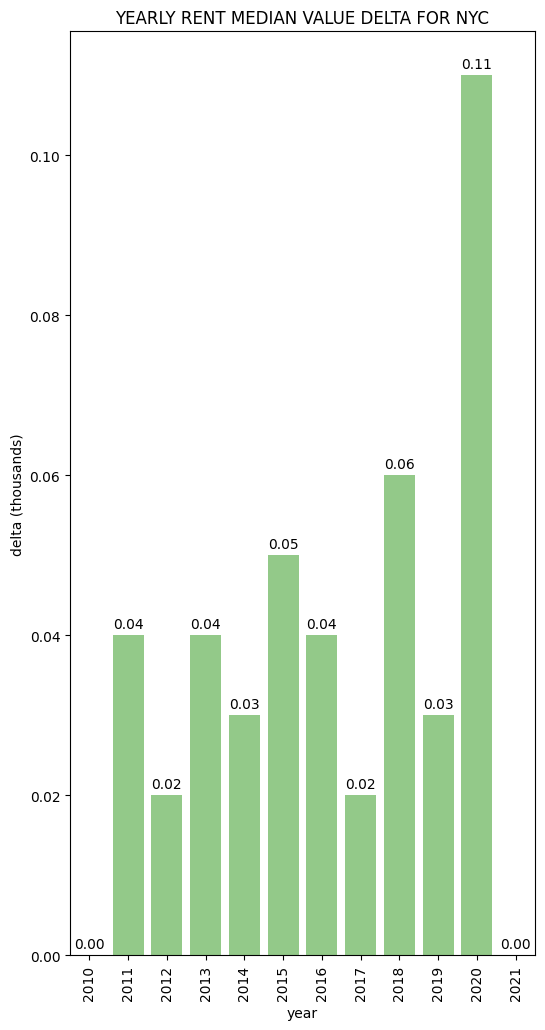

In [424]:
# Graph data for NYC
map_delta(nyc_delta, "")

In [425]:
# Create comparison chart for all boros and NYC (averaged) based on `value` column
def boro_comparison_line(df, value):
    data = df[["borough", "year", value]]
    nyc_data = get_nyc_data(df, value)
    data = pd.concat([data, nyc_data])
    
    chart = sns.lineplot(x="year", y=value, hue="borough", data=data)
    
    # Format Chart
    chart.axes.set_title(format_label(value))
    sns.move_legend(chart.axes, "upper left", bbox_to_anchor=(1, 1))

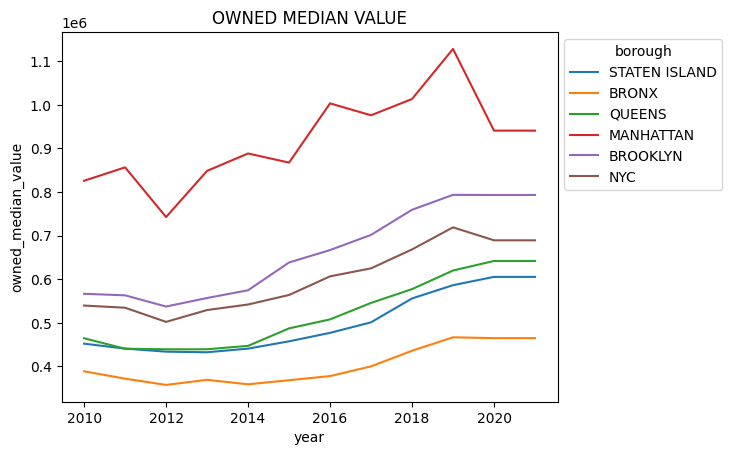

In [426]:
"""
Get boro comparison for specific column
Compares to rest of nyc (averaged on year to year basis)

total_housing_units
occupied_housing_units
vacant_housing_units

rent_median_value
owned_median_value
"""

boro_comparison_line(df, "owned_median_value")

In [429]:
# Create `boro` yearly comparison for columns in `values`
def nyc_comparison(df, values):
    comparison = ["year"] + values
    all_data = df[comparison]
    data = pd.melt(all_data, id_vars=["year" ], value_vars=values)
    data = data.groupby(["year", "variable"])["value"].mean().to_frame().reset_index()

    # Create ordering for y axis and render barplot
    data = data.sort_values(by=["variable"], ascending=False)
    order = [i for i in range(data["year"].max(), data["year"].min() - 1, -1)]

    chart = sns.barplot(data=data, y="year", x="value", hue="variable", palette="deep", orient="h", order=order)
    
    # Format Chart
    title = "NYC: {} vs {}".format(values[0], values[1])
    chart.axes.set_title(format_label(title))
    sns.move_legend(chart.axes, "upper left", bbox_to_anchor=(1, 1))

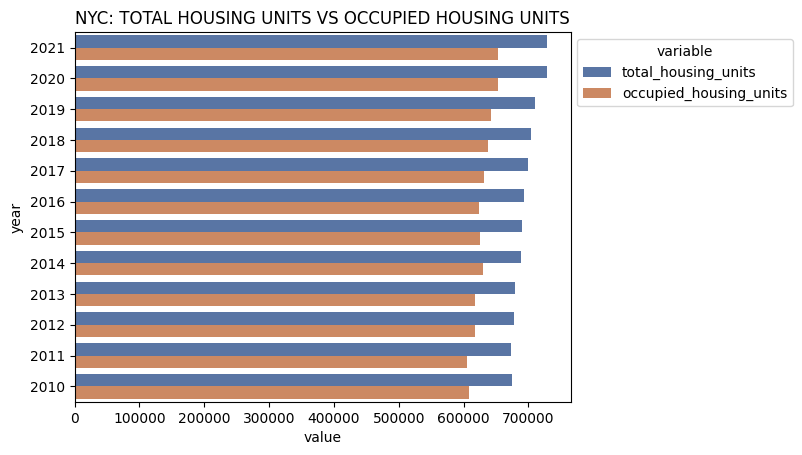

In [430]:
"""
Create comparison bar chart for NYC
For each year we compute the average median for all boroughs for the `value` columns
"""

nyc_comparison(df, ["total_housing_units", "occupied_housing_units"])